In [1]:
import pandas as pd
import numpy as np
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.5
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)

## Adult Neruonal Tissue DMR

In [3]:
adult_dmr_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/DMR/AdultNSDMRAnnotation/DMRAnnotation.h5ad'
)
adult_dmr_adata

AnnData object with n_obs × n_vars = 121067 × 139 
    var: 'FeatureType'

## Fetal Neuronal Tissue DMR

In [4]:
fetal_dmr_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/DMR/feDMRAnnotation_Brain/DMRAnnotation.h5ad'
)
fetal_dmr_adata

AnnData object with n_obs × n_vars = 213319 × 139 
    var: 'FeatureType'

## CEMBA DMR pass filter

In [5]:
dmr_adata = anndata.read_h5ad( 
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubDMRAnnotation/DMRAnnotation.h5ad'
)
dmr_adata = dmr_adata[:, dmr_adata.var['FeatureType'] != 'MotifHits']

dmr_hypo_hits = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/TotalHits.HypoDMR.h5ad'
)
use_dmr = dmr_hypo_hits.X.sum(axis=1).A1 > 0

dmr_adata = dmr_adata[use_dmr, :].copy()
dmr_adata

AnnData object with n_obs × n_vars = 3947795 × 139 
    var: 'FeatureType'

## Reptile hits

In [6]:
reptile_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/REPTILE/result/REPTILE_scores.subtype.h5ad'
)
enhancer_hits = pd.Series((reptile_adata.X > 0).sum(axis=1).A1, index=reptile_adata.obs_names)
dmr_adata.obs['IsEnhancer'] = enhancer_hits

In [7]:
enhancer_dmr_adata = dmr_adata[dmr_adata.obs['IsEnhancer'] > 0, :].copy()

## ATAC Peaks

In [8]:
atac_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/ATAC/peak/Annotation/DMRAnnotation.h5ad'
)

In [9]:
te_list = [
    'DNA.DNA', 'DNA.MULE-MuDR', 'DNA.MuDR', 'DNA.PiggyBac', 'DNA.TcMar',
    'DNA.TcMar-Mariner', 'DNA.TcMar-Pogo', 'DNA.TcMar-Tc2', 'DNA.TcMar-Tigger',
    'DNA.hAT', 'DNA.hAT-Blackjack', 'DNA.hAT-Charlie', 'DNA.hAT-Tip100',
    'LINE.CR1', 'LINE.Dong-R4', 'LINE.L1', 'LINE.L2', 'LINE.RTE-BovB',
    'LINE.RTE-X', 'LTR.ERV1', 'LTR.ERVK', 'LTR.ERVL', 'LTR.ERVL-MaLR',
    'LTR.Gypsy', 'LTR.LTR', 'SINE.Alu', 'SINE.B2', 'SINE.B4', 'SINE.Deu',
    'SINE.ID', 'SINE.MIR', 'SINE.tRNA'
]
cgi_related = ['CGI', 'CGI_Shore']

## Feature Portion Barplot

In [10]:
def get_feature_hits_count(adata):
    hits = pd.Series(adata.X.sum(axis=0).A1, index=adata.var_names)
    hits['TE_Total'] = hits[hits.index.isin(te_list)].sum()
    hits['CGI & shore'] = hits[hits.index.isin(cgi_related)].sum()
    hits['Intergenic'] = adata.X.shape[0] - hits['exon'] - hits['intron']
    
    no_hits = adata.X.shape[0] - hits
    return pd.DataFrame({'Hits': hits, 
                         'NoHits': no_hits})

In [11]:
records = []

counts = get_feature_hits_count(adult_dmr_adata)
counts['Type'] = 'tissueDMR'
records.append(counts)

counts = get_feature_hits_count(fetal_dmr_adata)
counts['Type'] = 'fetalDMR'
records.append(counts)

counts = get_feature_hits_count(dmr_adata)
counts['Type'] = 'ctDMR'
records.append(counts)

counts = get_feature_hits_count(enhancer_dmr_adata)
counts['Type'] = 'eDMR'
records.append(counts)

counts = get_feature_hits_count(atac_adata)
counts['Type'] = 'Peak'
records.append(counts)

total_counts = pd.concat(records)
total_counts['Ratio'] = total_counts['Hits'] / (total_counts['NoHits'] + total_counts['Hits']) * 100

In [12]:
plot_cates = [
    'CGI & shore', 'promoter', 'exon', 'intron', 'Intergenic', 'TE_Total'
]
titles = ['CGI &\nCGI Shore', 'Promoter', 'Exon', 'Intron', 'Intergenic', 'TE']

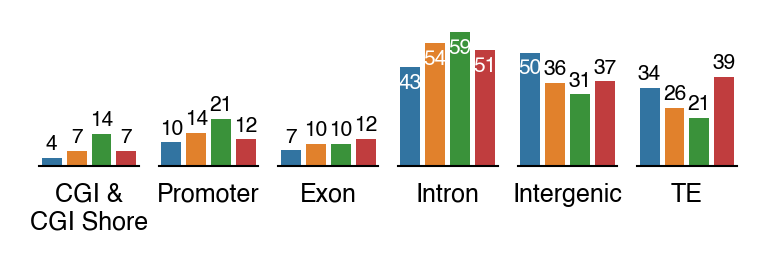

In [15]:
fig, axes = plt.subplots(figsize=(3, 0.6),
                         nrows=1,
                         ncols=6,
                         sharex=True,
                         sharey=True,
                         dpi=300)

order = ['ctDMR', 'eDMR', 'fetalDMR', 'Peak']

for ax, category, title in zip(axes.flat, plot_cates, titles):
    _data = total_counts[total_counts.index == category]
    sns.barplot(ax=ax, data=_data, x='Type', y='Ratio', order=order)
    ax.set(xlabel='', ylabel='', xticks=[], ylim=(0, 60), yticks=[])
    ax.set_xlabel(title, fontsize=labelsize)
    for i, dmr_type in enumerate(order):
        value = _data.set_index('Type')['Ratio'][dmr_type]
        if value > 40:
            va = 'center'
            c = 'w'
            dodge = -7
        else:
            va = 'center'
            c = 'k'
            dodge = 6
        ax.text(i,
                value + dodge,
                f'{int(round(value))}',
                rotation=0,
                fontsize=5,
                ha='center',
                va=va,
                c=c)
sns.despine(fig=fig, offset=0, left=True)
fig.savefig('Region_Composition.pdf')